In [128]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,datetime

import tensorflow as tf
import pandas as pd

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split

import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,Dropout,LSTM,Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Flatten

warnings.filterwarnings('ignore')
sns.set()

def delta_categorize(T,tf=15,kBins=5):
    data = []
    for day0 in range(len(T)-tf):
        data.append(T[day0+tf]-T[day0])
    data = np.stack(data,axis=0)
    bins = np.linspace(min(data),max(data),kBins)
    data = np.digitize(data,bins)
    return data

In [2]:
df = pd.read_csv('Data\\data1\\all_stocks_5yr.csv',infer_datetime_format=True)

In [3]:
ticker_list = list(set(df['Name'].values))

names = []
ind = []

for k in range(len(ticker_list)):
    ticker = df[df['Name']==ticker_list[k]].sort_values(by='date')['close'].values
    if ticker.shape[0]!=1259: continue
    names.append(ticker_list[k])
    ind.append(ticker)

tickers = np.vstack(ind)
names = np.vstack(names)

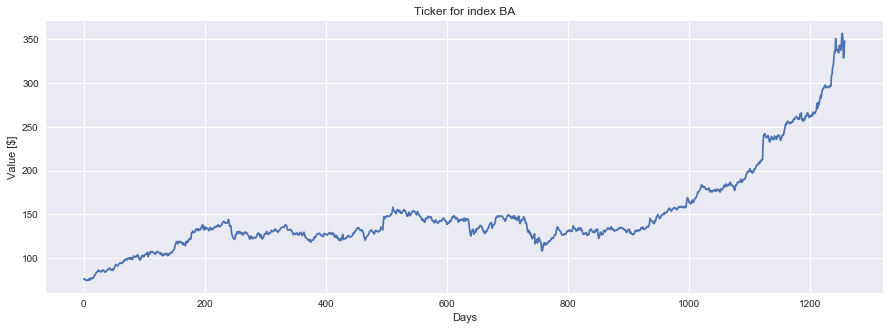

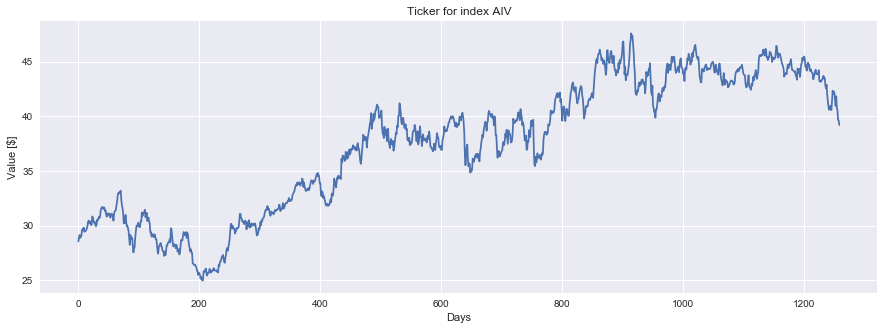

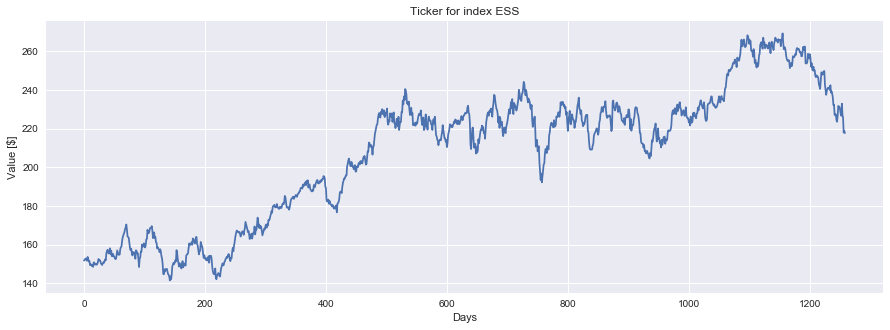

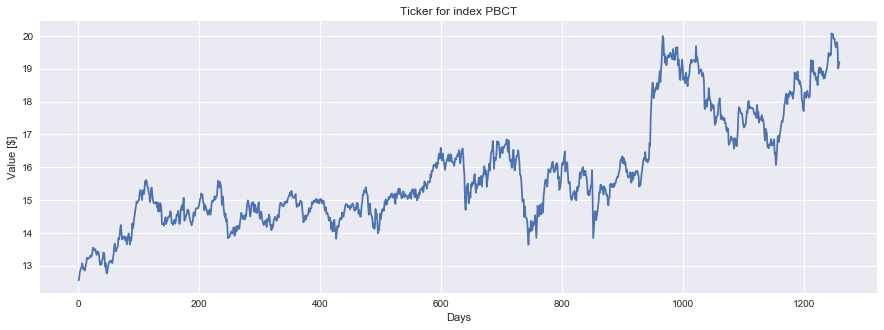

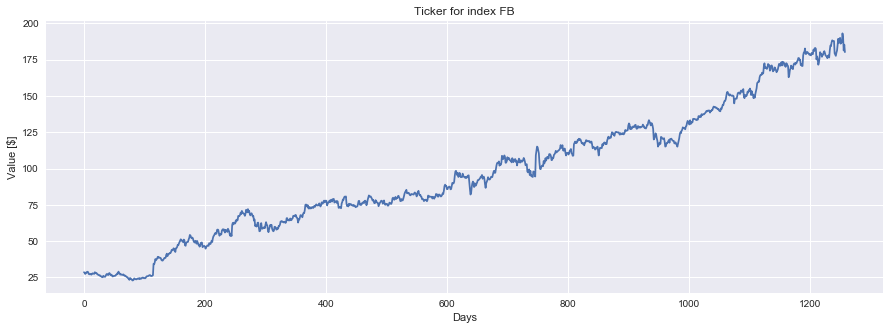

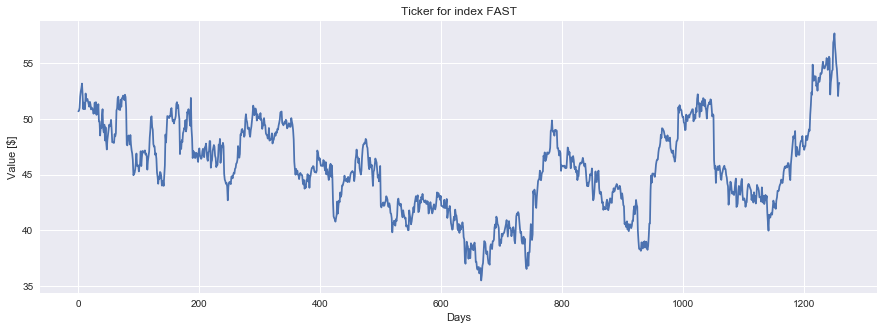

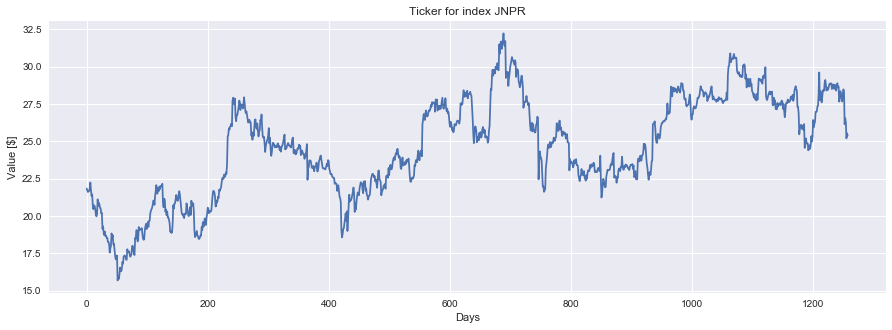

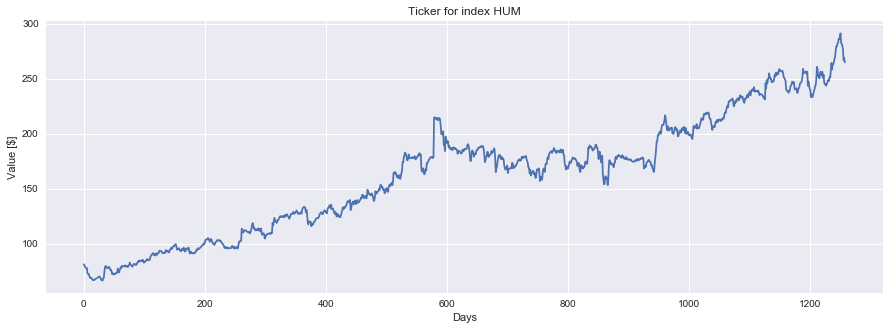

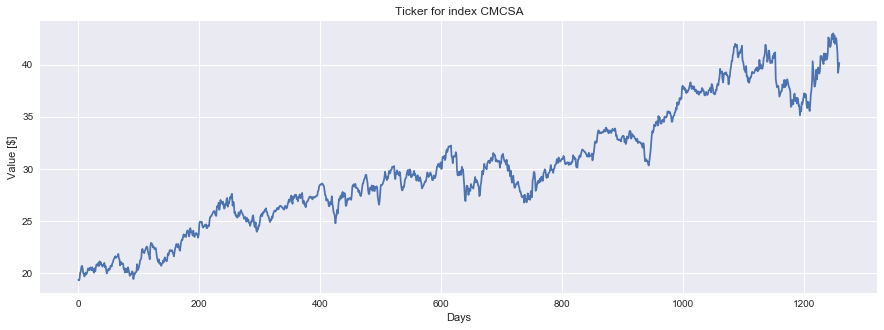

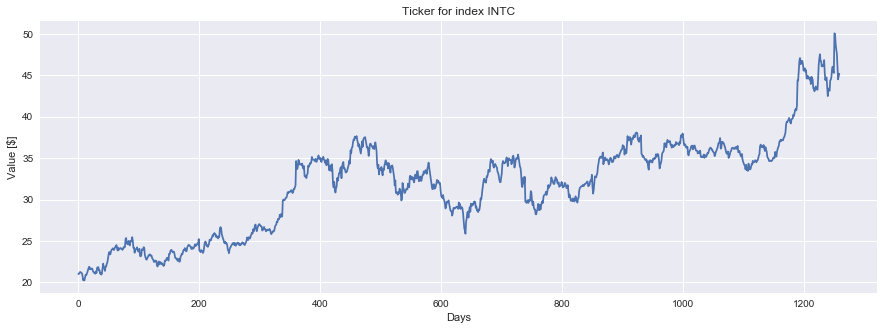

In [4]:
indices = rnd.permutation(np.arange(0,tickers.shape[0]))[:10]

for idx in indices:
    
    fig = plt.figure(figsize=(15,5))
    plt.plot(tickers[idx,:])
    plt.title('Ticker for index '+str(names[idx,0]))
    plt.xlabel('Days')
    plt.ylabel('Value [$]')
    plt.show()

In [5]:
# Use as input data the <lookback_len> last days value plus context vector

# Use as labels the change in value over the next <forecast_len> days, quantized to 
#   {high positive,positive,none,negative,high negative}

In [142]:
lookback = 75
forecast = 10

output_bins = 10

DATA = []
LABELS = []

for cID in range(tickers.shape[0]):
    ticker = tickers[cID]
    lbuffer = []
    for day in range(lookback,ticker.shape[0]-forecast):
        DATA.append(ticker[day-lookback:day])
        LABELS.append(ticker[day+forecast]-ticker[day])

bins = np.linspace(min(LABELS),max(LABELS),output_bins)
DATA = np.stack(DATA,axis=0)
LABELS = np.expand_dims(np.digitize(LABELS,bins),axis=1)

enc = pp.OneHotEncoder()
LABELS = enc.fit_transform(LABELS)

LABELS = LABELS.toarray()

print(bins)
print(np.bincount(np.argmax(LABELS,axis=1)))

[-286.57       -222.71888889 -158.86777778  -95.01666667  -31.16555556
   32.68555556   96.53666667  160.38777778  224.23888889  288.09      ]
[     6     17     59   1071 549165   1330    112     16      3      1]


In [143]:
indices0 = np.where(np.argmax(LABELS,axis=1)==4)[0]
deleterows = rnd.permutation(indices0)[:540000]

DATA = np.delete(DATA,deleterows,axis=0)
LABELS = np.delete(LABELS,deleterows,axis=0)

print(bins)
print(np.bincount(np.argmax(LABELS,axis=1)))

[-286.57       -222.71888889 -158.86777778  -95.01666667  -31.16555556
   32.68555556   96.53666667  160.38777778  224.23888889  288.09      ]
[   6   17   59 1071 9165 1330  112   16    3    1]


In [144]:
Xtrain,Xtest,ytrain,ytest = train_test_split(DATA,LABELS,test_size=0.1)

In [145]:
model = Sequential()

model.add(LSTM(units=100,input_shape=(lookback,1,)))
model.add(Dense(units=output_bins,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy')

In [150]:
in0 = Input(shape=(lookback,1,))
lstm0 = LSTM(units=100,activation='relu')(in0)
out0 = Dense(units=output_bins,activation='softmax')(lstm0)

model = Model(in0,out0)
model.compile(optimizer='RMSProp',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
model.fit(np.expand_dims(Xtrain,axis=2),ytrain,batch_size=10,epochs=2)

Epoch 1/2
10602/10602 [==============================] - 90s 9ms/step - loss: 8.7405 - categorical_accuracy: 0.4488
Epoch 2/2
 3540/10602 [=========>....................] - ETA: 1:24 - loss: 5.8327 - categorical_accuracy: 0.6381

In [147]:
model.evaluate(np.expand_dims(Xtest,axis=2),ytest)

1178/1178 [==============================] - 1s 1ms/step


0.3947045260657681